In [1]:
import sklearn
print(sklearn.__version__)


1.2.2


In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import joblib  # <-- thêm dòng này
from tqdm.notebook import tqdm
import os
from os import listdir
from os.path import isfile, join

import cv2


In [2]:
all_folders = ['Printed_extended', 'Handwritten_extended', 'Mixed_extended', 'Other_extended']
base_path = '/kaggle/input/prescription'

with open('/kaggle/working/res2.csv', 'w') as file:
    file.write("a1,a2,a3,a4,a5,res\n") 

    for folder in all_folders:
        folder_path = join(base_path, folder, folder)
        label = folder
        onlyfiles = [f for f in listdir(folder_path) if isfile(join(folder_path, f))]
        print(f"Processing {folder} with {len(onlyfiles)} files")

        for s in tqdm(onlyfiles, desc=folder):
            img = cv2.imread(join(folder_path, s))
            if img is None:
                continue
            rows, cols = img.shape[:2]
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, bwMask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            myavg = np.mean([(bwMask[:, x] == 0).sum() / rows for x in range(cols)])
            change = np.mean([(bwMask[row, :-1] != bwMask[row, 1:]).sum() / cols for row in range(rows)])
            file.write(f"{rows},{cols},{rows/cols},{myavg},{change},{label}\n")


Processing Printed_extended with 2880 files


Printed_extended:   0%|          | 0/2880 [00:00<?, ?it/s]

Processing Handwritten_extended with 3114 files


Handwritten_extended:   0%|          | 0/3114 [00:00<?, ?it/s]

Processing Mixed_extended with 126 files


Mixed_extended:   0%|          | 0/126 [00:00<?, ?it/s]

Processing Other_extended with 5220 files


Other_extended:   0%|          | 0/5220 [00:00<?, ?it/s]

In [4]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split
# from joblib import dump


# # Đọc dữ liệu với header giống tác giả
# df = pd.read_csv('/kaggle/working/res2.csv')  # Gồm cột: a1,a2,a3,a4,a5,res

# # Tách đặc trưng và nhãn
# X = df[['a1', 'a2', 'a3', 'a4', 'a5']]
# y = df['res']

# # Chia dữ liệu: 99% train, 1% test
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.99, random_state=42)

# # Huấn luyện model Random Forest
# model = RandomForestClassifier()
# model.fit(X_train, y_train)

# # Lưu model
# dump(model, '/kaggle/working/model.joblib')
# print("Training complete. Model saved!")

# # Đánh giá mô hình

Training complete. Model saved!


In [3]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import joblib  # <-- thêm dòng này
from tqdm.notebook import tqdm

df = pd.read_csv('/kaggle/input/resss2/res2.csv')  # Đảm bảo file tồn tại
X = df[['a1', 'a2', 'a3', 'a4', 'a5']]
y = df['res']

model = RandomForestClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')

y_true_all = []
y_pred_all = []

for train_index, test_index in tqdm (kfold.split(X, y), desc='training'):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_true_all.extend(y_test)
    y_pred_all.extend(y_pred)

# Lưu model sau vòng lặp cuối cùng
model.fit(X, y)
joblib.dump(model, '/kaggle/working/full_model.joblib')

conf_matrix = confusion_matrix(y_true_all, y_pred_all)
report = classification_report(y_true_all, y_pred_all, output_dict=True)

print("Mean Accuracy:", np.mean(accuracy_scores))
print("Std Deviation:", np.std(accuracy_scores))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", report)



training: 0it [00:00, ?it/s]

Mean Accuracy: 0.9987654320987656
Std Deviation: 0.0011292988073073936

Confusion Matrix:
 [[3104    0    2    8]
 [   0  126    0    0]
 [   0    0 5220    0]
 [   8    0    2 2870]]

Classification Report:
 {'Handwritten_extended': {'precision': 0.9974293059125964, 'recall': 0.9967886962106616, 'f1-score': 0.9971088981689687, 'support': 3114}, 'Mixed_extended': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 126}, 'Other_extended': {'precision': 0.9992343032159265, 'recall': 1.0, 'f1-score': 0.9996170049789354, 'support': 5220}, 'Printed_extended': {'precision': 0.9972202918693537, 'recall': 0.9965277777777778, 'f1-score': 0.9968739145536645, 'support': 2880}, 'accuracy': 0.9982363315696648, 'macro avg': {'precision': 0.9984709752494692, 'recall': 0.9983291184971098, 'f1-score': 0.9983999544253921, 'support': 11340}, 'weighted avg': {'precision': 0.9982356580231657, 'recall': 0.9982363315696648, 'f1-score': 0.9982358685011257, 'support': 11340}}


In [12]:
import os
from tqdm.notebook import tqdm
base_path = '/kaggle/input/prescription'
all_folders = ['Printed_extended', 'Handwritten_extended', 'Mixed_extended', 'Other_extended']

image_path_list = []

for folder in tqdm (all_folders, desc="sd"):
    folder_path = os.path.join(base_path, folder, folder)
    onlyfiles = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
    onlyfiles = sorted(onlyfiles)  # Đảm bảo cùng thứ tự nếu cần thiết
    for s in onlyfiles:
        image_path_list.append(os.path.join(folder_path, s))


sd:   0%|          | 0/4 [00:00<?, ?it/s]

Number of misclassified samples: 12


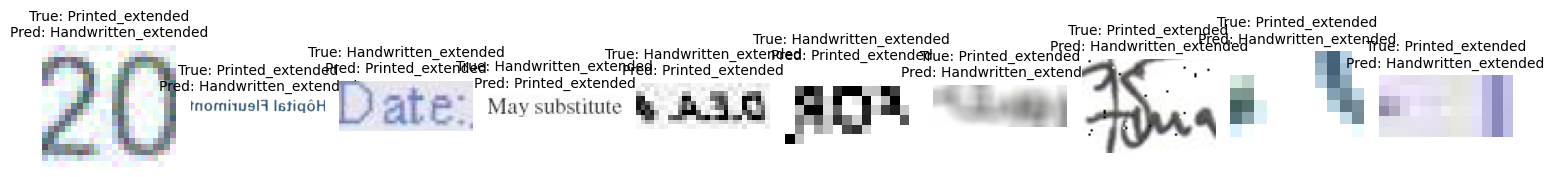

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Chuyển y_true_all, y_pred_all về numpy array
y_true_all = np.array(y_true_all)
y_pred_all = np.array(y_pred_all)

mis_idx = np.where(y_true_all != y_pred_all)[0]

print(f"Number of misclassified samples: {len(mis_idx)}")

num_plot = min(10, len(mis_idx))
plt.figure(figsize=(15, 4))

for i, idx in enumerate(mis_idx[:num_plot]):
    img_path = image_path_list[idx]
    img = plt.imread(img_path)
    true_label = y_true_all[idx]
    pred_label = y_pred_all[idx]
    
    plt.subplot(1, num_plot, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


In [5]:
for label, metrics in report.items():
    if isinstance(metrics, dict):
        print(f"{label:20} - Precision: {metrics['precision']:.3f}, Recall: {metrics['recall']:.3f}, F1-score: {metrics['f1-score']:.3f}, Support: {metrics['support']}")
# print(f"\nAccuracy: {accuracy_score(y_true, y_pred):.3f}")

Handwritten_extended - Precision: 0.999, Recall: 0.998, F1-score: 0.998, Support: 3114
Mixed_extended       - Precision: 1.000, Recall: 1.000, F1-score: 1.000, Support: 126
Other_extended       - Precision: 1.000, Recall: 1.000, F1-score: 1.000, Support: 5220
Printed_extended     - Precision: 0.998, Recall: 0.998, F1-score: 0.998, Support: 2880
macro avg            - Precision: 0.999, Recall: 0.999, F1-score: 0.999, Support: 11340
weighted avg         - Precision: 0.999, Recall: 0.999, F1-score: 0.999, Support: 11340


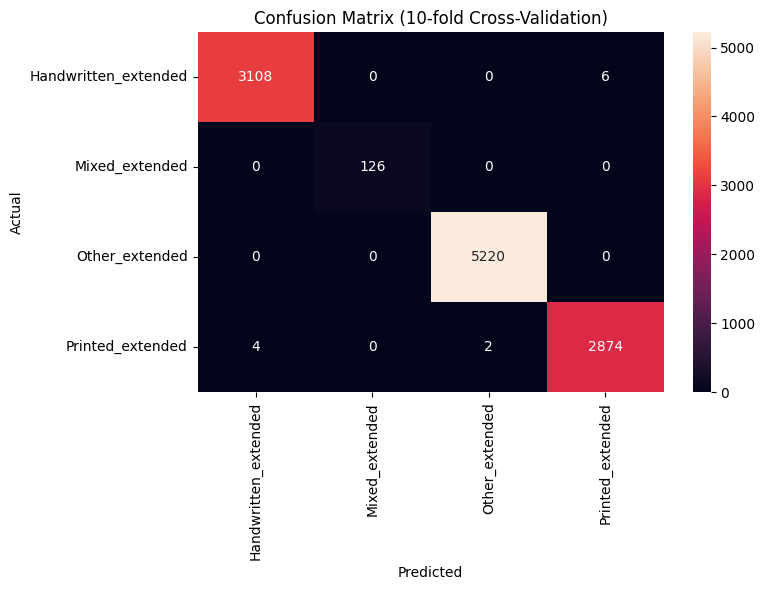

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

# Đảm bảo đúng thứ tự nhãn như Table 4
labels_order = ['Handwritten_extended', 'Mixed_extended', 'Other_extended', 'Printed_extended']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='rocket',
            xticklabels=labels_order, yticklabels=labels_order)

plt.title("Confusion Matrix (10-fold Cross-Validation)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [3]:
import cv2
import numpy as np
from joblib import load

model = load("/kaggle/input/fullll/other/default/1/full_model.joblib")

# def extract_features(img_crop):
#     gray = cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
#     _, bw = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#     rows, cols = bw.shape
#     aspect_ratio = rows / cols
#     htr = np.mean([(bw[:, x] == 0).sum() / rows for x in range(cols)])
#     tcr = np.mean([(bw[y, :-1] != bw[y, 1:]).sum() / cols for y in range(rows)])
#     return [rows, cols, aspect_ratio, htr, tcr]

def extract_features(img):
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    rows = img.shape[0]
    cols = img.shape[1]
    arr = [rows, cols, rows / cols if cols > 0 else 0]
    retval, bwMask = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    myavg = 0
    for xx in range(cols):
        mycnt = 0
        for yy in range(rows):
            if bwMask[yy, xx] == 0:
                mycnt += 1
        myavg += (mycnt * 1.0) / rows
    myavg /= cols if cols > 0 else 1
    arr.append(myavg)
    change = 0
    for xx in range(rows):
        mycnt = 0
        for yy in range(cols - 1):
            if (bwMask[xx, yy] == 0) != (bwMask[xx, yy + 1] == 0):
                mycnt += 1
        change += (mycnt * 1.0) / cols if cols > 0 else 1
    change /= rows if rows > 0 else 1
    arr.append(change)
    return arr
    
def group_into_lines(boxes, y_threshold=10):
    lines = []
    for box in sorted(boxes, key=lambda b: b[1]):  # sort by top y
        x, y, w, h = box
        placed = False
        for line in lines:
            _, ly, _, lh = line[0]
            if abs(y - ly) < y_threshold:  # same line
                line.append(box)
                placed = True
                break
        if not placed:
            lines.append([box])
    return lines

def sort_boxes_top_to_bottom_left_to_right(boxes):
    lines = group_into_lines(boxes)
    sorted_boxes = []
    for line in lines:
        sorted_line = sorted(line, key=lambda b: b[0])  # sort by x
        sorted_boxes.extend(sorted_line)
    return sorted_boxes

def predict_blocks(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    original = img.copy()

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    linek = np.zeros((11, 11), dtype=np.uint8)
    linek[5, :] = 1
    x = cv2.morphologyEx(gray, cv2.MORPH_OPEN, linek)
    gray = gray - x
    _, bw = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    bw = cv2.dilate(bw, np.ones((5, 5), np.uint8), iterations=1)

    contours, _ = cv2.findContours(bw, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours top-to-bottom, then left-to-right
    # bounding_boxes = [cv2.boundingRect(c) for c in contours]
    # sorted_contours = [cnt for _, cnt in sorted(zip(bounding_boxes, contours), key=lambda b: (b[0][1], b[0][0]))]
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    sorted_boxes = sort_boxes_top_to_bottom_left_to_right(bounding_boxes)
    sorted_contours = [contours[bounding_boxes.index(b)] for b in sorted_boxes]

    
    results = []
    block_index = 0

    for cnt in sorted_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w < 10 or h < 10:
            continue
        roi = original[y:y+h, x:x+w]
        feat = extract_features(roi)
        pred = model.predict([feat])[0]
        results.append(f"Block #{block_index}: {pred}")
        cv2.rectangle(original, (x, y), (x+w, y+h), (0, 255, 0), 1)  # Viền mỏng hơn
        cv2.putText(original, f"#{block_index}", (x, y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)  # Màu đỏ

        block_index += 1

    result_img = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
    result_text = "\n".join(results)
    return result_img, result_text

import gradio as gr

gr.Interface(
    fn=predict_blocks,
    inputs=gr.Image(type="numpy", label=""),
    outputs=[
        gr.Image(type="numpy", label=""),
        gr.Textbox(label="Box Index → Label Mapping")
    ],
    title="Prescription Block Classifier (with Index Labels)"
).launch()

* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://b37bafbd6cecbef594.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X

In [2]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 27.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 84.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 2.3 MB/s eta 0:00:00
